# Well-being and Nutrition

In this notebook, we would like to study the link between well-being and nutrition.

More precisely, our goal is to analyze if it is possible to predict the healthiness of an area from publicly available well-being data. We will study results at the level of London city wards, as this is the highest granularity we could find for general well-being data.

## Context

From Tesco Grocery 1.0, a large-scale dataset of grocery purchases in London paper, we were able to understand how the nutritional informations of the average product of an area could help to predict the prevalence of common diseases, such as diabetes. We were interested in the relationship between nutrition and general well-being indicators. However, data on general well-being is available to the general public for almost any city, while nutritional data has to be anonymized and is distributed among different private companies such as Tesco. We therefore aim to predict the nutritional information of the average product per area based on well-being measures.

The City of London has conducted many studies and surveys on the well-being of its inhabitants, so it was not too difficult to find the required datasets to follow our studies. However, it would have been preferable to work with datasets at a higher granularity (LSOA or MSOA), as some phenomena might be smoothened out by bigger areas.

## Data

Our study will use two datasets:

1) The data provided by the Tesco Grocery 1.0 paper (`year_osward_grocery`) giving the nutritional informations of the average product per ward, the representativeness of Tesco's data and some additional information such as population, gender, and age.

2) The well-being probability score dataset from [London datastore] (https://data.london.gov.uk/). This data is from 2013. However, we can make the assumption that the well-being values do not significantly change in two years. It is an spreadsheet computing the total wellbeing per area in 2013 based on different categories (Health, Education, financial aspects, etc.). The spreadsheet is interactive, and therefore allows to weigh each category differently to compute the final well-being score. We decided to put the same weight to every category except the subjective well-being (self-stated happiness feeling), as we want to make predictions based on objective and measurable input. The well-being Index Score is thus a mean of all the objective variables.

You can find the well-being dataframe in the `data` folder (`./data/london-ward-well-being-probability-scores.xls`). We used the "score" page which gives the scores of the different variables for each area.

The well-being index score is calculated as follows: $score = \frac{data(area) - data(England \, and \, Wales)}{Standard \, Deviation}$

Therefore, if the score is positive, it means that the well-being variable is higher than UK's mean value for this area.


We provide a brief description of the fields you will encounter:

- `area_id`: the number for each area of London at ward scale.

- `Life_Expectancy`: Index scores were reversed so higher life expectancy equals better well-being. Source: ONS mortality data and GLA population projections, GLA Calculations.

- `Childhood Obesity`: Children with a BMI greater than or equal to the 95th centile of the British 1990 growth reference (UK90) BMI distribution have been classified as obese. Source: National Obesity Observatory.		

- `Incapacity Benefit rate`: Incapacity Benefit (IB) is paid to people who are incapable of work and who meet certain contribution conditions. Severe Disablement Allowance (SDA) is paid to those unable to work for 28 weeks in a row or more because of illness or disability. Source: IB/SDA from DWP, Population from GLA projections.

- `Unemployement rate`: Percentage of working-age residents claiming Jobseeker's Allowance (JSA) or National Insurance Credits. JSA is a benefit payable to unemployed people. In general, to be entitled to claim a person must be available for work, be actively seeking work, and have entered into a Jobseeker's Agreement with Jobcentre Plus. Source: JSA from DWP, Population from GLA projections.

- `Crime rate - index`: Index scores of overall notifiable offences per 1,000 daytime population. Source: MPS, Home Office, and ONS Workday population 2011 Census.

- `Deliberate fires`: Rate of all Deliberate Fire incidents (arson) recorded by the London Fire & Emergency Planning Authority per 1,000 population. Source: LFEPA via LASS team at GLA, and Population from GLA 2012 projections.

- `Average Capped GCSE and Equivalent Point Score Per Pupil`: GCSE and Equivalent point scores for pupils at the end of Key Stage 4 (KS4) in maintained schools (Referenced by Location of Pupil Residence). Ward data calculated by apportioning Lower Layer Super Output Area (LSOA) data. Index scores were reversed so higher GCSE scores equals better well-being. Source: DfE (on Neighbourhood Statistics).

- `Unauthorised Absence in All Schools (%)`: Pupil Absence in all maintained schools (Referenced by Location of Pupil Residence). Unauthorised Absence is absence without permission from a teacher or other authorised representative of the school. Ward data calculated by apportioning Lower Layer Super Output Area (LSOA) data. Source: DfE (on Neighbourhood Statistics).

- `Dependent children in out-of-work families`: Data represent the number of children dependent on a parent or guardian who is claiming one or a combination of out-of-work benefits. Source: DWP and GLA 2012 population projections.

- `Public Transport Accessibility`: take into account walk access time and service availability. The method is essentially a way of measuring the density of the public transport network at any location within Greater London. Each area was given an average score out of 8, where 8 is the highest level of accessibility. Open space was removed from the data as no population lives there. (Source: PTAL contours from Transport for London, further calculations by [GLA](http://www.tfl.gov.uk/businessandpartners/syndication/16493.aspx))

- `Homes with access to open space & nature, and % greenspace`:  There are four types of public open space according to the 2011 London Plan. Homes further away than the maximum recommended distance are considered to be deficient in access to that type of public open space. Access to nature measures the proportion of homes with good access to nature. The final measure is the proportion of area that is greenspace within the ward. In these combined scores, each of the three measures has been given a weight of 33%. (Source: Greenspace Information for Greater London, and Ordnance Survey)

## Import modules

In [1]:
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFE

from statsmodels.stats import diagnostic
from statsmodels.stats.weightstats import ttost_ind
from statsmodels.stats.multitest import multipletests

from utils import calculate_nutripoints

sns.set_theme('notebook')
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

## I) Import data

In [3]:
year_grocery = pd.read_csv("data/year_osward_grocery.csv")
display(year_grocery.head())

# for wellbeing_score, we have to get the scores of the individual variable in the "Scores" sheet
# and the final score, which is the mean of all the variables, in the "Ranked" sheet

wellbeing_scores = pd.read_excel(
    "data/london-ward-well-being-probability-scores.xls", sheet_name="Scores", header=[0, 1])
display(wellbeing_scores.head())

wellbeing_final_scores = pd.read_excel(
    "data/london-ward-well-being-probability-scores.xls", sheet_name="Ranked", header=[3], usecols="B:C")
display(wellbeing_final_scores.head())

,area_id,weight,weight_perc2.5,weight_perc25,weight_perc50,weight_perc75,weight_perc97.5,weight_std,weight_ci95,volume,...,man_day,population,male,female,age_0_17,age_18_64,age_65+,avg_age,area_sq_km,people_per_sq_km
0,E05000026,449.535137,32.5,166.4,300.0,500.0,1500.0,771.349423,3.716832,125.960833,...,37315,14370.0,7469.0,6901.0,4211.0,9421.0,738.0,29.572999,1.26,11404.761905
1,E05000027,413.130263,32.5,150.0,300.0,500.0,1500.0,626.395178,5.164174,110.664114,...,14474,10845.0,5228.0,5617.0,3205.0,6608.0,1032.0,33.568004,1.36,7974.264706
2,E05000028,407.100472,32.5,160.0,300.0,500.0,1200.0,545.890959,2.710677,121.990710,...,32138,13856.0,6750.0,7106.0,4180.0,8537.0,1139.0,32.032693,1.29,10741.085271
3,E05000029,384.173858,30.0,150.0,250.0,454.0,1500.0,591.837557,4.968373,122.245578,...,16223,10850.0,5300.0,5550.0,3023.0,6251.0,1576.0,36.004793,3.38,3210.059172
4,E05000030,356.882607,30.0,140.0,250.0,450.0,1000.0,465.284180,3.880963,109.959688,...,17522,11348.0,5515.0,5833.0,2747.0,6961.0,1640.0,37.247444,3.45,3289.275362


Old Ward Code New ward code       Ward name               Borough  \
  Old Ward Code New ward code       Ward name               Borough   
0          00AA     E09000001  City of London        City of London   
1        00ABFX     E05000026           Abbey  Barking and Dagenham   
2        00ABFY     E05000027          Alibon  Barking and Dagenham   
3        00ABFZ     E05000028       Becontree  Barking and Dagenham   
4        00ABGA     E05000029  Chadwell Heath  Barking and Dagenham   

  Life Expectancy                                              \
             2009       2010       2011       2012       2013   
0         18.7787  14.927723  13.653698  16.026485  23.661861   
1         9.10692   9.583198   6.867900   1.417979   4.251859   
2        -9.12595  -8.474883  -9.670047 -11.527627  -9.035117   
3        -6.54069  -5.702701  -7.855704  -7.727404  -7.975613   
4       -0.285993  -2.129908  -0.888760  -3.151067  -1.211477   

  Childhood Obesity  ...  \
               2009  ...   
0          -7.17432  ...   
1          -6.11698  ...   
2          -14.8205  ...   
3           -7.6407  ...   
4          -10.3826  ...   

  Homes with access to open space & nature, and % greenspace            \
                                                        2009      2010   
0                                           -9.52981         -9.529812   
1                                           -1.30845         -1.308451   
2                                           -2.63439         -2.634394   
3                                           -8.04551         -8.045513   
4                                            2.90909          2.909091   

                                Subjective well-being average score  \
       2011      2012      2013                                2009   
0 -9.529812 -9.529812 -9.529812                                   0   
1 -1.308451 -1.308451 -1.308451                             8.09781   
2 -2.634394 -2.634394 -2.634394                            -8.84788   
3 -8.045513 -8.045513 -8.045513                           -0.980979   
4  2.909091  2.909091  2.909091                             -16.729   

                                              
        2010       2011       2012      2013  
0   0.000000   0.000000   0.000000  0.000000  
1   8.097813   8.097813   8.097813  6.118185  
2  -8.847876  -8.847876  -8.847876 -4.726708  
3  -0.980979  -0.980979  -0.980979 -4.813479  
4 -16.729023 -16.729023 -16.729023 -4.813479  

[5 rows x 64 columns]

,Index Score 2013,Ward
0,17.217884,Knightsbridge and Belgravia
1,13.741583,Campden
2,11.572839,West Wickham
3,11.566019,South Twickenham
4,11.435223,East Sheen


## II) Preprocessing

### A) Filter data

We consider only 80% of the areas, the ones with the highest representativeness. Indeed, they do the same thing in Tesco paper in order to have more robust results.

In [4]:
PERCENTAGE_SPLIT_REPRESENTATIVENESS = 0.8
N = len(year_grocery)

year_grocery = year_grocery.nlargest(
    int(PERCENTAGE_SPLIT_REPRESENTATIVENESS * N), 'representativeness_norm')

### B) Compute nutripoints

To predict the nutritional variables of the average product per area, we thought it would be easier to assess a single variable representative of the individual ones per nutrients. We called it nutripoints. 

We based our computation of the nutripoints on the definition of the French national Nutriscore. The bigger it is, the worse is the average product regarding the level of sugar, saturate, sodium and total energy it has. On the other hand, if it is negative (which is almost impossible), it represents products with higher level of proteins and fibers than "bad nutrients" (salt, sugar, saturate). We adapted the different ranges of the official formula to our database as we have average products and therefore very close data. You can see the detailed function in the file: `utils.py`

We then add a column with the computed nutripoints to our `year_grocery` dataset, which is the one with the nutritional values, assessing the quality of the average product of each London ward.

In [5]:
year_grocery["nutripoints"] = year_grocery.apply(calculate_nutripoints, axis=1)
year_grocery["nutripoints"].describe()

count    510.000000
mean       9.237255
std        1.469929
min        0.500000
25%        8.500000
50%        9.000000
75%       10.000000
max       14.500000
Name: nutripoints, dtype: float64

In [6]:
display(year_grocery.head())

,area_id,weight,weight_perc2.5,weight_perc25,weight_perc50,weight_perc75,weight_perc97.5,weight_std,weight_ci95,volume,...,population,male,female,age_0_17,age_18_64,age_65+,avg_age,area_sq_km,people_per_sq_km,nutripoints
570,E05011117,382.039628,40.0,175.0,300.0,500.0,1000.0,363.202381,0.465398,105.990925,...,11911.0,6099.0,5812.0,1558.0,9552.0,801.0,34.867937,1.35,8822.962963,8.5
565,E05011112,398.825948,40.0,180.0,320.0,500.0,1000.0,397.149657,0.492467,107.602664,...,16365.0,8103.0,8262.0,2997.0,12218.0,1150.0,33.235625,1.30,12588.461538,8.0
246,E05000336,397.066289,40.0,180.0,300.0,500.0,1000.0,414.783419,0.608474,122.609742,...,11959.0,5764.0,6195.0,2625.0,7194.0,2140.0,40.250941,3.32,3602.108434,10.0
438,E05000605,416.199096,40.5,182.0,325.0,500.0,1200.0,506.239533,0.700727,107.997869,...,13599.0,7196.0,6403.0,2630.0,9919.0,1050.0,34.684389,1.31,10380.916031,9.0
162,E05000252,374.792470,40.0,173.7,300.0,500.0,1000.0,354.119901,0.563867,99.371843,...,12013.0,5828.0,6185.0,1709.0,8813.0,1491.0,37.502289,0.89,13497.752809,8.5


In [7]:
print(year_grocery['area_id'].duplicated().any())

False


Our nutripoints are distributed from 0.5 to 14.5; having an interval of 14. However, as the mean is at 9.2 and the 1st and 3rd quartiles are at respectively 8 and 10, we see that most of the values lie between 8 and 10. The min and max values must be outliers.

This will actually complicate our study, as there might not be many differences or at least considerable differences between the areas. It is probably because we have the average product per area.

[//]: # "Indeed, London's inhabitants buy mainly the same type of foods but not the same quality, according to their budget."

###  C) Filter wellbeing data

We filter the columns in order to keep only the information from the last year of the dataset, 2013. We remove NaN values in order to have a clean dataset without any missing values. 

In [8]:
# only keep the columns containing 2013 and the code and name of the ward

wellbeing_scores = wellbeing_scores.loc[:, (slice(
    None), [2013, "New ward code", "Ward name"])].dropna(how="all")

# We first had two levels of indexes, one with the years and the other with the type of variable
# Now that we only keep 2013, we drop the second level of line indexes.
wellbeing_scores = wellbeing_scores.droplevel(1, axis=1)

display(wellbeing_scores.head())

,New ward code,Ward name,Life Expectancy,Childhood Obesity,Incapacity Benefit rate,Unemployment rate,Crime rate - Index,Deliberate Fires,Average Capped GCSE and Equivalent Point Score Per Pupil,Unauthorised Absence in All Schools (%),Dependent children in out-of-work families,Public Transport Accessibility,"Homes with access to open space & nature, and % greenspace",Subjective well-being average score
0,E09000001,City of London,23.661861,-19.399351,15.136349,8.610513,17.205862,5.606699,10.348951,11.827561,8.094587,29.202424,-9.529812,0.000000
1,E05000026,Abbey,4.251859,-8.272848,3.953790,-11.228402,-18.441350,-15.314186,-4.528620,-7.570297,-9.420035,15.818063,-1.308451,6.118185
2,E05000027,Alibon,-9.035117,-12.944834,-20.398595,-15.084810,-9.218119,-3.905882,-10.941296,-11.507206,-17.164782,-4.501940,-2.634394,-4.726708
3,E05000028,Becontree,-7.975613,-18.487966,-7.354425,-14.275467,-13.060348,1.890929,-12.819252,-10.803760,-16.413721,-6.460879,-8.045513,-4.813479
4,E05000029,Chadwell Heath,-1.211477,-19.346426,-11.983294,-10.292302,-6.060588,-31.284887,-6.503490,-14.903977,-12.907861,-10.826177,2.909091,-4.813479


In [9]:
wellbeing_scores_columns = wellbeing_scores.columns.values.tolist()
print(wellbeing_scores_columns)

['New ward code', 'Ward name', 'Life Expectancy', 'Childhood Obesity', 'Incapacity Benefit rate', 'Unemployment rate', 'Crime rate - Index', 'Deliberate Fires', 'Average Capped GCSE and Equivalent Point Score Per Pupil', 'Unauthorised Absence in All Schools (%)', 'Dependent children in out-of-work families', 'Public Transport Accessibility', 'Homes with access to open space & nature, and % greenspace', 'Subjective well-being average score']


### D) Merge datasets

After this step, we will be able to do some exploratory data analysis, understanding the link between wellbeing and nutrition. To do so, we first merge the two datasets keeping only the columns that are interesting to put in parallel.

First of all, we merge the two wellbeing datasets in order to have the Total Wellbeing score (column `Index Score 2013`) with all its components used to compute it. 

Then, we select the energy for each nutrient, the entropy and the nutripoints from `year_grocery`. These variables will be used to represent the nutritional information of the Nutrition datatset. 

In [10]:
# Merging the two wellbeing datasets according to the ward name in order to have the Total score in only one wellbeing dataset
wellbeing_scores = pd.merge(
    left=wellbeing_scores, right=wellbeing_final_scores, left_on='Ward name', right_on="Ward")
wellbeing_scores = wellbeing_scores.drop("Ward", axis=1)
display(wellbeing_scores.head())

,New ward code,Ward name,Life Expectancy,Childhood Obesity,Incapacity Benefit rate,Unemployment rate,Crime rate - Index,Deliberate Fires,Average Capped GCSE and Equivalent Point Score Per Pupil,Unauthorised Absence in All Schools (%),Dependent children in out-of-work families,Public Transport Accessibility,"Homes with access to open space & nature, and % greenspace",Subjective well-being average score,Index Score 2013
0,E09000001,City of London,23.661861,-19.399351,15.136349,8.610513,17.205862,5.606699,10.348951,11.827561,8.094587,29.202424,-9.529812,0.000000,8.397137
1,E05000026,Abbey,4.251859,-8.272848,3.953790,-11.228402,-18.441350,-15.314186,-4.528620,-7.570297,-9.420035,15.818063,-1.308451,6.118185,5.158493
2,E05000026,Abbey,4.251859,-8.272848,3.953790,-11.228402,-18.441350,-15.314186,-4.528620,-7.570297,-9.420035,15.818063,-1.308451,6.118185,-3.828524
3,E05000455,Abbey,1.954939,6.874674,14.659226,9.631054,1.193650,2.594187,8.906345,10.408799,3.096512,9.678513,-1.195187,-5.900801,5.158493
4,E05000455,Abbey,1.954939,6.874674,14.659226,9.631054,1.193650,2.594187,8.906345,10.408799,3.096512,9.678513,-1.195187,-5.900801,-3.828524


In [11]:
# Selection of the columns of interest in year_grocery dataset
list_column = ["area_id", "energy_tot", "energy_fat", "energy_saturate", "energy_sugar", "energy_protein",
               "energy_carb", "energy_fibre", "energy_alcohol", "h_nutrients_calories", "nutripoints"]
year_grocery = year_grocery.loc[:,
                                year_grocery.columns.isin(list(list_column))]
display(year_grocery.head())

,area_id,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,energy_alcohol,energy_tot,h_nutrients_calories,nutripoints
570,E05011117,78.438016,30.789383,34.635855,22.770981,65.237562,3.026622,1.892084,171.365266,1.608028,8.5
565,E05011112,78.516170,30.681996,36.415653,22.396706,68.789239,2.984949,1.558974,174.246039,1.589399,8.0
246,E05000336,78.864004,32.414378,38.719523,21.433875,71.160848,2.994211,1.741239,176.194176,1.582813,10.0
438,E05000605,84.561946,33.918637,36.141050,22.015479,69.832483,3.067818,1.697021,181.174746,1.575484,9.0
162,E05000252,80.542785,31.635739,33.648475,22.141379,61.322242,3.149138,1.689631,168.845175,1.598050,8.5


In [12]:
# Merging the 2 datasets of interest: year grocery and wellbeing scores according to the ward name
wellbeing_grocery = pd.merge(
    left=year_grocery, right=wellbeing_scores, left_on='area_id', right_on="New ward code")
wellbeing_grocery = wellbeing_grocery.drop("New ward code", axis=1)
display(wellbeing_grocery.head())

,area_id,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,energy_alcohol,energy_tot,h_nutrients_calories,...,Unemployment rate,Crime rate - Index,Deliberate Fires,Average Capped GCSE and Equivalent Point Score Per Pupil,Unauthorised Absence in All Schools (%),Dependent children in out-of-work families,Public Transport Accessibility,"Homes with access to open space & nature, and % greenspace",Subjective well-being average score,Index Score 2013
0,E05000336,78.864004,32.414378,38.719523,21.433875,71.160848,2.994211,1.741239,176.194176,1.582813,...,7.382849,5.663200,1.732487,9.104353,14.362369,6.829642,-12.410936,5.496664,0.097080,4.798106
1,E05000605,84.561946,33.918637,36.141050,22.015479,69.832483,3.067818,1.697021,181.174746,1.575484,...,-6.415999,-17.140935,6.149262,5.553690,2.833274,2.724538,12.165452,-4.355219,4.064134,0.440499
2,E05000252,80.542785,31.635739,33.648475,22.141379,61.322242,3.149138,1.689631,168.845175,1.598050,...,2.223858,5.477066,9.517488,18.843265,0.391431,4.402315,16.172939,-14.255212,9.646084,4.269507
3,E05000427,77.568453,30.521094,35.742617,22.364672,66.992603,2.985766,1.760651,171.672145,1.600125,...,-11.114732,-13.774964,8.269988,4.929764,7.254350,-10.552446,18.059347,-13.621024,1.783860,-2.659193
4,E05000595,82.975277,33.302798,37.707033,21.336347,71.447922,2.947414,1.372449,180.079409,1.559561,...,-5.951363,-6.697261,2.509921,-5.728663,-1.420357,3.504061,4.092038,9.694047,4.064134,-0.489500


In [13]:
# Checking for any null values in the new dataset
wellbeing_grocery_columns = wellbeing_grocery.columns.values.tolist()
wellbeing_grocery.isnull().any()

area_id                                                       False
energy_fat                                                    False
energy_saturate                                               False
energy_sugar                                                  False
energy_protein                                                False
energy_carb                                                   False
energy_fibre                                                  False
energy_alcohol                                                False
energy_tot                                                    False
h_nutrients_calories                                          False
nutripoints                                                   False
Ward name                                                     False
Life Expectancy                                               False
Childhood Obesity                                             False
Incapacity Benefit rate                         

Our dataset of study is complete as there is no NA values in any of our columns.

In [14]:
# Understanding better our each variable is organized: its min, max, mean, standard deviation and quartiles
wellbeing_grocery.describe()

,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,energy_alcohol,energy_tot,h_nutrients_calories,nutripoints,...,Unemployment rate,Crime rate - Index,Deliberate Fires,Average Capped GCSE and Equivalent Point Score Per Pupil,Unauthorised Absence in All Schools (%),Dependent children in out-of-work families,Public Transport Accessibility,"Homes with access to open space & nature, and % greenspace",Subjective well-being average score,Index Score 2013
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,...,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,80.774453,31.908111,40.271732,21.063283,72.074066,3.029884,1.682096,178.623782,1.572242,9.288647,...,-2.559664,-5.637407,1.664926,4.140902,0.491332,-1.570287,0.086403,-0.640641,-0.945463,-0.411776
std,2.815440,1.371391,3.241331,0.911611,5.328385,0.120886,0.350880,6.931980,0.024423,1.377576,...,9.729277,9.203556,8.501475,9.749412,10.420337,9.295638,9.509300,9.927869,9.739047,5.121256
min,67.111854,26.283257,33.119113,17.596480,58.462154,2.750710,0.715793,156.104396,1.465237,5.000000,...,-54.658671,-47.737871,-44.322159,-24.274349,-33.740795,-27.284950,-16.720060,-32.738196,-22.995993,-13.819509
25%,79.111206,31.039763,38.087105,20.605970,68.294016,2.947507,1.438488,174.137633,1.556396,8.500000,...,-8.459775,-10.406264,-1.714313,-3.010887,-5.986843,-7.827685,-7.096940,-7.672257,-8.974028,-4.143008
50%,80.526276,31.767310,39.797617,21.262472,72.080308,3.022995,1.671868,178.673453,1.573805,9.000000,...,-0.437333,-4.053333,3.876656,3.653406,1.326355,-2.041617,-2.668173,-0.621308,-0.364830,-0.199689
75%,82.248204,32.643980,42.239147,21.684800,75.886539,3.102445,1.887892,182.731751,1.590084,10.500000,...,5.161143,0.686241,7.416967,10.526070,7.913508,5.851170,5.702022,6.257372,4.148313,3.109617
max,92.440804,38.690892,48.719140,23.005837,84.618879,3.617668,3.147601,197.674474,1.641436,14.500000,...,12.594709,11.838724,11.357859,31.306345,23.799230,18.603360,30.159917,26.930630,22.945127,11.435223


For our analysis, we will create a database from our merged one (`wellbeing_grocery`) keeping only the numerical variables. 

In [15]:
# List of columns of interest in the wellbeing dataset
COLUMNS_SCORES = [
    'Life Expectancy',
    'Childhood Obesity',
    'Incapacity Benefit rate',
    'Unemployment rate',
    'Crime rate - Index',
    'Deliberate Fires',
    'Average Capped GCSE and Equivalent Point Score Per Pupil',
    'Unauthorised Absence in All Schools (%)',
    'Dependent children in out-of-work families',
    'Public Transport Accessibility',
    'Homes with access to open space & nature, and % greenspace',
    'Subjective well-being average score',
    'Index Score 2013'
]

# List of columns of interest in the nutritional dataset
COLUMNS_GROCERY = [
    'energy_fat',
    'energy_saturate',
    'energy_sugar',
    'energy_protein',
    'energy_carb',
    'energy_fibre',
    'energy_alcohol',
    'energy_tot',
    'h_nutrients_calories',
    'nutripoints'
]

COLUMNS = COLUMNS_GROCERY + COLUMNS_SCORES

# Selection of the numerical columns of interest in the wellbeing_grocery dataset
wellbeing_grocery_analysis = wellbeing_grocery[COLUMNS].copy()

In [16]:
# standardizing features by removing the mean and scaling to unit variance
scaler = StandardScaler()
wellbeing_grocery_analysis[wellbeing_grocery_analysis.columns] = scaler.fit_transform(wellbeing_grocery_analysis
                                                                                      [wellbeing_grocery_analysis.columns])
wellbeing_grocery_analysis.describe()

,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,energy_alcohol,energy_tot,h_nutrients_calories,nutripoints,...,Unemployment rate,Crime rate - Index,Deliberate Fires,Average Capped GCSE and Equivalent Point Score Per Pupil,Unauthorised Absence in All Schools (%),Dependent children in out-of-work families,Public Transport Accessibility,"Homes with access to open space & nature, and % greenspace",Subjective well-being average score,Index Score 2013
count,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02,...,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02
mean,2.402802e-16,3.775831e-16,-1.819264e-15,-1.484588e-15,5.663746e-16,-5.835375e-16,-1.351576e-16,7.894919e-16,6.933799e-15,-1.287215e-16,...,-1.287215e-17,2.145359e-17,-8.581434e-18,-1.287215e-17,4.290717e-18,-1.287215e-17,8.581434e-18,1.823555e-17,-4.290717e-17,-1.287215e-17
std,1.001210e+00,1.001210e+00,1.001210e+00,1.001210e+00,1.001210e+00,1.001210e+00,1.001210e+00,1.001210e+00,1.001210e+00,1.001210e+00,...,1.001210e+00,1.001210e+00,1.001210e+00,1.001210e+00,1.001210e+00,1.001210e+00,1.001210e+00,1.001210e+00,1.001210e+00,1.001210e+00
min,-4.858612e+00,-4.106531e+00,-2.209362e+00,-3.807545e+00,-2.557694e+00,-2.312199e+00,-2.757274e+00,-3.252553e+00,-4.386729e+00,-3.116950e+00,...,-5.361349e+00,-4.579904e+00,-5.415851e+00,-2.918087e+00,-3.289101e+00,-2.769662e+00,-1.769510e+00,-3.236988e+00,-2.266876e+00,-2.621223e+00
25%,-5.914738e-01,-6.339534e-01,-6.748060e-01,-5.022616e-01,-7.102759e-01,-6.822733e-01,-6.951179e-01,-6.479501e-01,-6.496369e-01,-5.731818e-01,...,-6.071623e-01,-5.187806e-01,-3.979695e-01,-7.344486e-01,-6.224379e-01,-6.739686e-01,-7.563159e-01,-7.091274e-01,-8.253661e-01,-7.294591e-01
50%,-8.825514e-02,-1.027941e-01,-1.464485e-01,2.187660e-01,1.172799e-03,-5.706061e-02,-2.918486e-02,7.174067e-03,6.406804e-02,-2.097863e-01,...,2.184025e-01,1.723237e-01,2.604732e-01,-5.006307e-02,8.023090e-02,-5.076569e-02,-2.900224e-01,1.949633e-03,5.969118e-02,4.146312e-02
75%,5.240866e-01,5.372358e-01,6.077119e-01,6.826036e-01,7.163681e-01,6.009698e-01,5.872242e-01,5.933283e-01,7.314173e-01,8.804002e-01,...,7.945244e-01,6.879187e-01,6.774120e-01,6.557210e-01,7.131397e-01,7.993466e-01,5.912542e-01,6.956537e-01,5.236590e-01,6.884352e-01
max,4.148718e+00,4.951899e+00,2.609308e+00,2.133481e+00,2.357185e+00,4.868205e+00,4.181711e+00,2.751558e+00,2.836632e+00,3.787564e+00,...,1.559490e+00,1.901143e+00,1.141527e+00,2.789739e+00,2.239476e+00,2.172853e+00,3.166364e+00,2.780519e+00,2.456041e+00,2.316098e+00


## III) Exploratory Data Analysis

In this part, we will do some tests putting in parralel the wellbeing variables and the nutritional variables to analyse if they are correlated and therefore if we coul really use one to predict the other. 

### A) Repartition of the values for each variable

Text(0.5, 0.98, 'Boxplot for each wellbeing and nutritional variable')

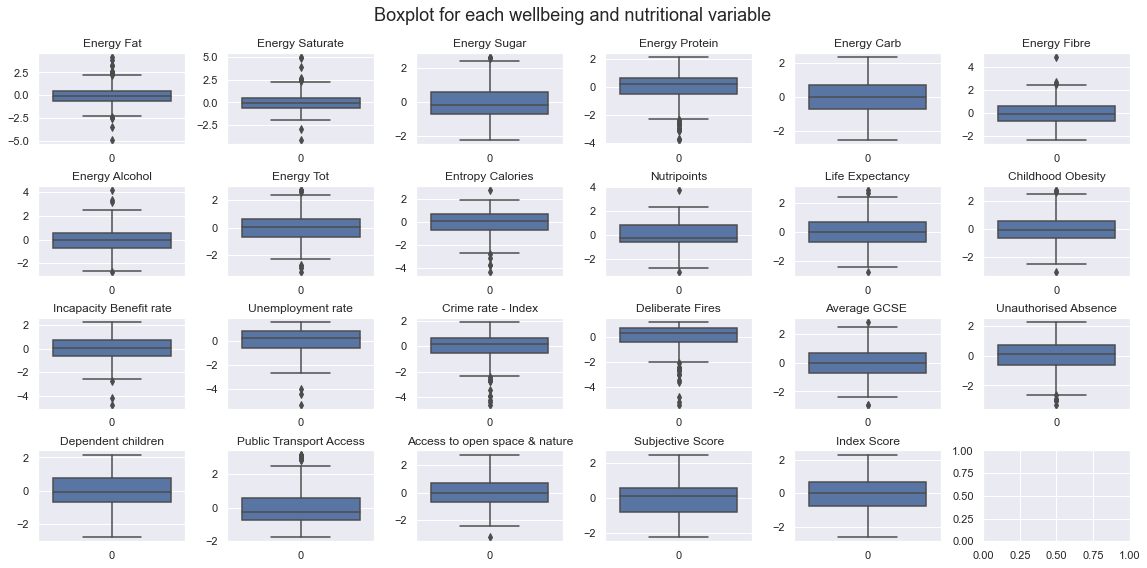

In [17]:
# Shortening the name of the columns in order to make graphs clearer
COLUMNS_SHORT = [
    'Energy Fat',
    'Energy Saturate',
    'Energy Sugar',
    'Energy Protein',
    'Energy Carb',
    'Energy Fibre',
    'Energy Alcohol',
    'Energy Tot',
    'Entropy Calories',
    'Nutripoints',
    'Life Expectancy',
    'Childhood Obesity',
    'Incapacity Benefit rate',
    'Unemployment rate',
    'Crime rate - Index',
    'Deliberate Fires',
    'Average GCSE ',
    'Unauthorised Absence',
    'Dependent children',
    'Public Transport Access',
    'Access to open space & nature',
    'Subjective Score',
    'Index Score'
]


# Explanatory data analysis: visually show the distribution of the values for each variable thanks to boxplot
fig, ax = plt.subplots(4, 6, figsize=(16, 8), sharey=False)

for i in range(len(COLUMNS)):
    sbplt = ax[int(i/6), i % 6]

    sns.boxplot(data=wellbeing_grocery_analysis.iloc[:, i], ax=sbplt)
    sbplt.set_xlabel('')
    sbplt.set_ylabel('')
    sbplt.set_title(COLUMNS_SHORT[i], loc='center', wrap=True)

fig.tight_layout()
fig.subplots_adjust(top=0.9)

fig.suptitle('Boxplot for each wellbeing and nutritional variable', fontsize=18)

These boxplots give us a general view of the distribution of each variables. Since we would like to cluster nutrient data for specific areas and predict nutrional habits according to well-being characteristics, it is important to observe difference between areas for the different features. Here, the nutrional as well as the wellbeing features seems to take various values between the different wards. Moreover, some outliers can sometimes be seen, for example for the energy saturate and the crime rate. 


Text(0.5, 0.98, 'Distplot for each nutritional ')

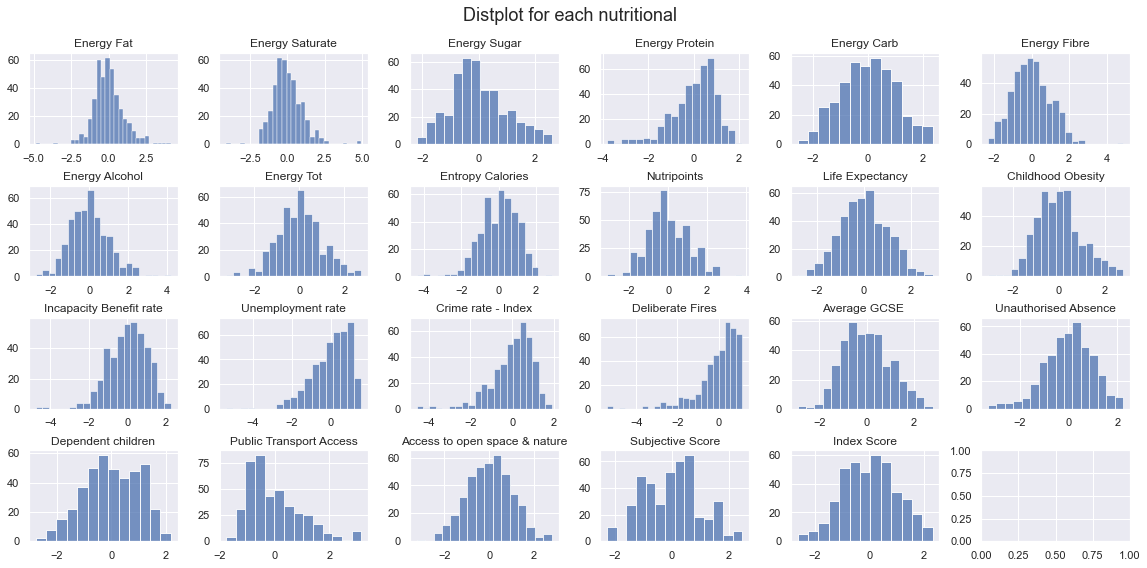

In [18]:
# Explanatory data analysis: distribution of the different variables by counting the number of observations per value
fig, ax = plt.subplots(4, 6, figsize=(16, 8), sharey=False)

for i in range(len(COLUMNS)):
    sbplt = ax[int(i/6), i % 6]

    sns.histplot(wellbeing_grocery_analysis.iloc[:, i], ax=sbplt)
    sbplt.set_xlabel('')
    sbplt.set_ylabel('')
    sbplt.set_title(COLUMNS_SHORT[i], wrap=True)

fig.tight_layout()
fig.subplots_adjust(top=0.9)

fig.suptitle('Distplot for each nutritional ', fontsize=18)

It seems that certain variables follow a normal distribution, let's check: 

In [19]:
# checking for any normal distribution
for i in range(len(COLUMNS)):
    print(wellbeing_grocery_analysis.columns[i], diagnostic.kstest_normal(
        wellbeing_grocery_analysis.iloc[:, i], dist='norm'))

energy_fat (0.07903216865905405, 0.0009999999999998899)
energy_saturate (0.05326903182093623, 0.007581189826131957)
energy_sugar (0.07251996494284862, 0.0009999999999998899)
energy_protein (0.08876799457406159, 0.0009999999999998899)
energy_carb (0.026851481287560097, 0.6903939704884319)
energy_fibre (0.038606909345865525, 0.16346729546429065)
energy_alcohol (0.05190847073443838, 0.009968381379691995)
energy_tot (0.03103558001885176, 0.4594223025890827)
h_nutrients_calories (0.05360270195456229, 0.0069957442091933535)
nutripoints (0.12404662721690057, 0.0009999999999998899)
Life Expectancy (0.03202904042931304, 0.412173758424854)
Childhood Obesity (0.0554713286478391, 0.004272239753128864)
Incapacity Benefit rate (0.03829769415806922, 0.17191349500448455)
Unemployment rate (0.09308541477110721, 0.0009999999999998899)
Crime rate - Index (0.10222109516633626, 0.0009999999999998899)
Deliberate Fires (0.12711248129388664, 0.0009999999999998899)
Average Capped GCSE and Equivalent Point Scor

The second value returned by the function is the p-value. When the p_value < 0.05 -> we can reject the null hypothesis that the data comes from a normal distribution!
Here, we observe that:  
-Carbs  
-Fibres  
-Energy_total  
-Life Expectancy  
-Incapacity Benefit rate  
-Unauthorised Absence in All Schools  
-Homes with access to open space & nature, and % greenspace  
-Index Score 2013   
have a p-value > 0.05. 
Therefore, the null hypothesis is not rejected and we can say that those variables follow a normal distribution 

### B) Correlation study
After checking how each variable is organised: its interval, mean and standard deviation, we will now observe the correlation between our nutripoints resuming nutritional ifnormations and each wellbeing variable. 

<AxesSubplot:>

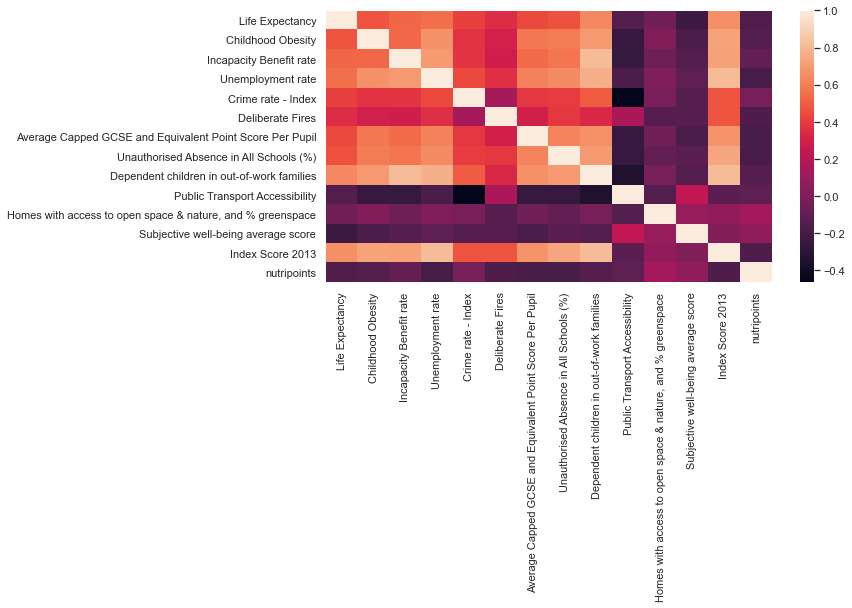

In [20]:
# Computing and plotting the correlation between the well-being scores and nutripoints
fig = plt.figure(figsize=(10, 5))

sns.heatmap(
    wellbeing_grocery_analysis[COLUMNS_SCORES + ['nutripoints']].corr())

This heatmap helps us visualise the correlation between the different variables. If we focus on nutripoints line with the wellbeing, we can see actually that the correlation is quite low because it is mainly purple corresponding to the negative correlation values and they are all below 0.4 which is not high. This is not a good augur for the continuation of the project.


In [21]:
# Computing the correlation between the different variables from the dataset according to the spearman method
correlation = wellbeing_grocery_analysis.corr(method="spearman")
display(correlation)

,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,energy_alcohol,energy_tot,h_nutrients_calories,nutripoints,...,Unemployment rate,Crime rate - Index,Deliberate Fires,Average Capped GCSE and Equivalent Point Score Per Pupil,Unauthorised Absence in All Schools (%),Dependent children in out-of-work families,Public Transport Accessibility,"Homes with access to open space & nature, and % greenspace",Subjective well-being average score,Index Score 2013
energy_fat,1.000000,0.794008,0.518320,-0.051129,0.528766,-0.022809,-0.306844,0.760485,-0.554516,0.484302,...,-0.170388,0.010652,-0.176290,-0.083693,-0.039851,-0.012980,-0.253005,0.212674,0.167257,-0.051765
energy_saturate,0.794008,1.000000,0.420225,-0.172299,0.325855,-0.061581,-0.169905,0.506666,-0.414911,0.590893,...,0.051839,0.176281,0.012804,0.053995,0.140953,0.165477,-0.276443,0.182293,0.008602,0.139416
energy_sugar,0.518320,0.420225,1.000000,-0.517745,0.843177,-0.299513,-0.397929,0.780870,-0.777506,0.436790,...,-0.099329,0.242386,-0.315661,-0.033822,0.069130,0.007639,-0.492036,0.021304,0.051887,-0.080296
energy_protein,-0.051129,-0.172299,-0.517745,1.000000,-0.316860,0.374254,0.302556,-0.145463,0.551938,-0.315371,...,0.077650,-0.142165,0.094958,0.012193,-0.020728,-0.046501,0.119329,0.112256,0.060965,0.041988
energy_carb,0.528766,0.325855,0.843177,-0.316860,1.000000,-0.355920,-0.585464,0.932636,-0.860796,0.232162,...,-0.314781,0.126398,-0.417559,-0.170743,-0.085563,-0.141283,-0.505008,-0.006541,0.041767,-0.271345
energy_fibre,-0.022809,-0.061581,-0.299513,0.374254,-0.355920,1.000000,0.167844,-0.242023,0.413188,-0.453616,...,0.659100,0.279590,0.380703,0.503871,0.518466,0.556797,-0.084597,0.027839,-0.056576,0.620441
energy_alcohol,-0.306844,-0.169905,-0.397929,0.302556,-0.585464,0.167844,1.000000,-0.504350,0.805775,0.083176,...,0.308832,-0.088154,0.223652,0.135398,0.126966,0.162501,0.269470,0.081716,0.003030,0.247782
energy_tot,0.760485,0.506666,0.780870,-0.145463,0.932636,-0.242023,-0.504350,1.000000,-0.787751,0.316234,...,-0.302588,0.080201,-0.384443,-0.161635,-0.089986,-0.124365,-0.471491,0.099475,0.107429,-0.229348
h_nutrients_calories,-0.554516,-0.414911,-0.777506,0.551938,-0.860796,0.413188,0.805775,-0.787751,1.000000,-0.291113,...,0.375696,-0.091720,0.349449,0.190620,0.134059,0.171759,0.391602,0.034879,-0.017220,0.295569
nutripoints,0.484302,0.590893,0.436790,-0.315371,0.232162,-0.453616,0.083176,0.316234,-0.291113,1.000000,...,-0.204867,-0.038874,-0.158829,-0.156403,-0.160991,-0.136101,-0.080805,0.108918,0.045825,-0.145147


From the results obtained for the heatmap, we decided to analyse if it was only the nutripoints that was not well correlated with the wellbeing variables or if we coul also observed this phenomenom for the other nutritional variables (energis and entropy). 

Text(0.5, 0.98, 'Spearman Correlation')

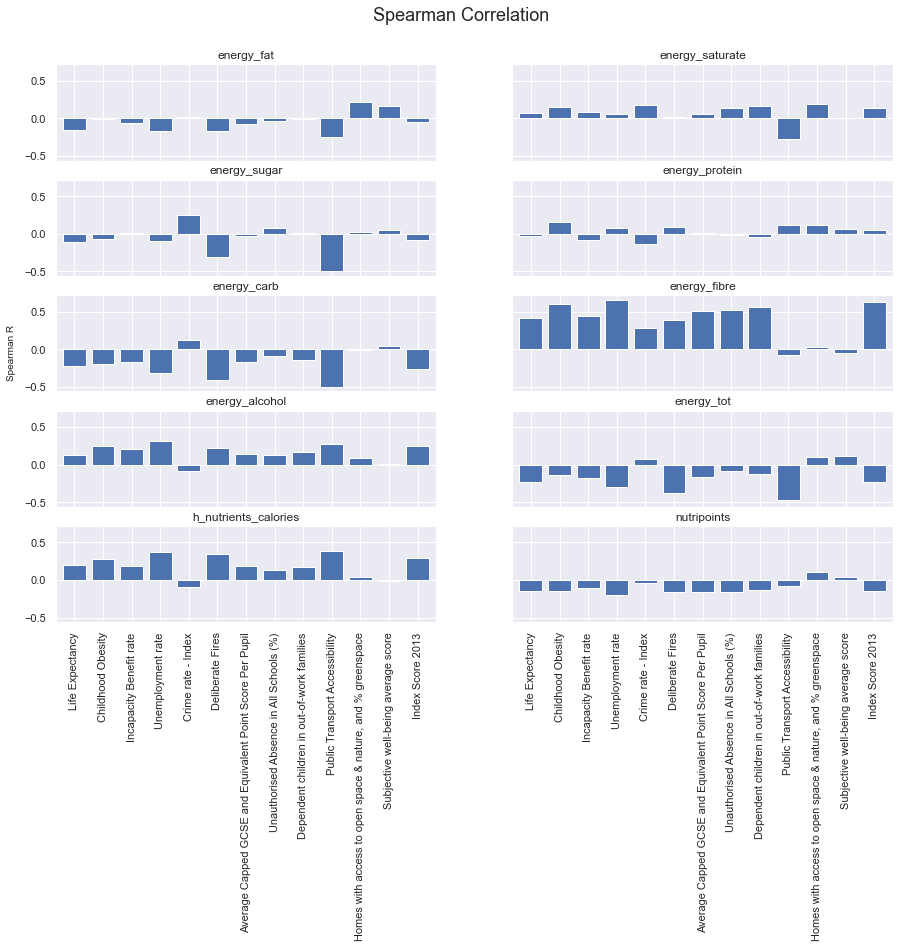

In [22]:
fig, ax = plt.subplots(5, 2, figsize=(15, 10), sharex=True, sharey=True)

for i in range(len(COLUMNS_GROCERY)):
    sbplt = ax[int(i/2), i % 2]

    correlation[COLUMNS_GROCERY[i]][COLUMNS_SCORES].plot.bar(
        x=None, y=None, width=0.8, legend=None, ax=sbplt)
    sbplt.set_title(wellbeing_grocery_analysis.columns[i], wrap=True)


fig.text(0.08, 0.5, 'Spearman R', va='center', rotation='vertical')
fig.subplots_adjust(top=0.9)

fig.suptitle("Spearman Correlation", fontsize=18)

We can observe on the graphs below that the correlation is very low for all the nutritional variables. They never exceed 0.2 except for energy_carb (and therefore sugar), energy_fibre, energy_tot and entropy. Therefore, it would be a bit difficult to predict nutripoints from the wellbeing variables because they only have a few impact on the nutritional aspect of an area.


### C) Regression analysis

We have seen that wellbeing variables is actually not very correlated to the nutritional ones. However, to be sure about it, we want to test some regressions and observe the R-squared and p values for each coefficient.

We will try predicting entropy and fibre (the nutritional values with the highest correlation), with the wellbeing variables that seem the most linked to nutrition, in our opinion. Indeed, we could think that if unemployement is high, people have less money to spend in healthy food and would like to eat comforting food. Furthermore, childhood obesity must be linked to unhealthy food high in fat and sugar. 

In [23]:
# Selection of the wellbeing features that seem correlated to nutrition, in our opinion
reg_features = 'Q("Life Expectancy") + Q("Incapacity Benefit rate") + Q("Unemployment rate") + Q("Crime rate - Index") \
+ Q("Childhood Obesity") + Q("Homes with access to open space & nature, and % greenspace")'

# Linear regression to rpedict entropy from those features
mod = smf.ols(formula='h_nutrients_calories ~ ' +
              reg_features, data=wellbeing_grocery_analysis)
res = mod.fit()
print(res.summary())

                             OLS Regression Results                             
Dep. Variable:     h_nutrients_calories   R-squared:                       0.245
Model:                              OLS   Adj. R-squared:                  0.234
Method:                   Least Squares   F-statistic:                     21.98
Date:                  Sun, 13 Dec 2020   Prob (F-statistic):           2.02e-22
Time:                          12:49:14   Log-Likelihood:                -529.33
No. Observations:                   414   AIC:                             1073.
Df Residuals:                       407   BIC:                             1101.
Df Model:                             6                                         
Covariance Type:              nonrobust                                         
                                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

In [24]:
# Linear regression to predict energy_fibre
mod = smf.ols(formula='energy_fibre ~ ' + reg_features,
              data=wellbeing_grocery_analysis)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           energy_fibre   R-squared:                       0.436
Model:                            OLS   Adj. R-squared:                  0.428
Method:                 Least Squares   F-statistic:                     52.48
Date:                Sun, 13 Dec 2020   Prob (F-statistic):           9.22e-48
Time:                        12:49:14   Log-Likelihood:                -468.83
No. Observations:                 414   AIC:                             951.7
Df Residuals:                     407   BIC:                             979.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

### D) Clustering 

In order to understand better how the nutripoints are spread and to see if we can identify some clusters linked to wellbeing features, we will process through Kmeans. First, we do a PCA in order to put in 2D the different wellbeing variables.

#### PCA

In [25]:
# PCA on the wellbeing features
wellbeing_scores_analysis = wellbeing_scores[COLUMNS_SCORES]\
    .dropna().copy()
wellbeing_scores_reduced_pca = PCA(n_components=2).fit(
    wellbeing_scores_analysis).transform(wellbeing_scores_analysis)

We know that the positive scores are better than the England average whereas the negative are worst. We could then labellise our datapoints regarding their Index score (mean of all the wellbeing variables). If they are green, they have a better total wellbeing, they are red if they are worst than Engaland mean. 

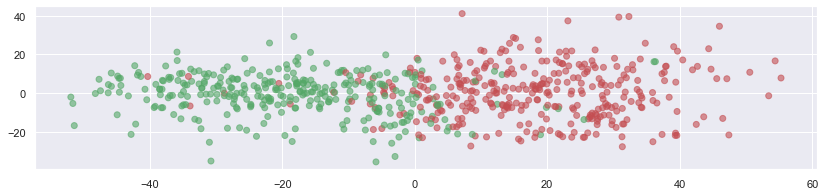

In [26]:
# Labellisation as explained above
labels = wellbeing_scores_analysis.apply(
    lambda row: "g" if row['Index Score 2013'] >= 0 else "r", axis=1)

# Plot the data reduced in 2d space with PCA
plt.figure(figsize=(14, 3))
plt.scatter(wellbeing_scores_reduced_pca[:, 0],
            wellbeing_scores_reduced_pca[:, 1], c=labels, alpha=0.6)

After doing this PCA, we actually can observe that the points are aggregated depending on the sign of the Total wellbeing score. We will now try to observe if the nutripoints can be organised in clusters. We apply this to year_grocery as we want to take the distribution for all the wards and not only the ones for which we also have wellbeing values. 

To understand how many clusters we can determine for the nutripoints, we first plot the Sum of squared erros curve for each number of cluster. It is called the elbow method. Indeed, the point where the curve actually point should be the best number of clusters for this dataset. 
To confirm our choice, we will also do the silhouette score. This curve represents the score assessed for each number of clusters. When tehre is a peak in the curve, it is a good nuber of cluster. 

#### Kmeans 

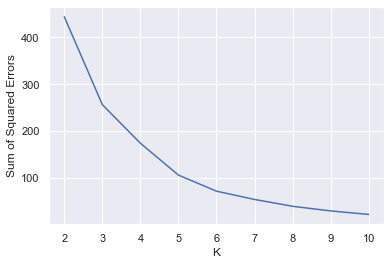

In [27]:
# Election of the column we would like to determine the number of clusters for: here it is the nutripoints
columns_kmeans = ['nutripoints']
year_grocery_kmeans = year_grocery[columns_kmeans].copy()

# Function to plot the sse


def plot_sse(X, start=2, end=11):
    sse = []
    for k in range(start, end):
        # Assign the labels to the clusters
        kmeans = KMeans(n_clusters=k, random_state=10).fit(X)
        sse.append({"k": k, "sse": kmeans.inertia_})
    sse = pd.DataFrame(sse)
    # Plot the data
    plt.plot(sse.k, sse.sse)
    plt.xlabel("K")
    plt.ylabel("Sum of Squared Errors")


plot_sse(year_grocery_kmeans)

Text(0, 0.5, 'Silhouette score')

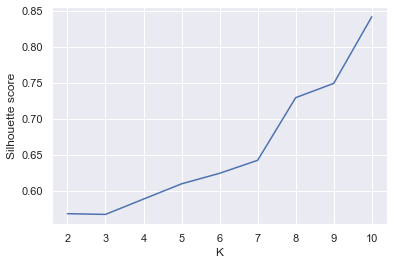

In [30]:
# 2nd method to choose k: the silhouette score
silhouettes = []

# Trying for k between 2 and 10
for k in range(2, 11):
    # Cluster the data and assign the labels
    labels = KMeans(n_clusters=k, random_state=10).fit_predict(
        year_grocery_kmeans)
    # Get the Silhouette score
    score = silhouette_score(year_grocery_kmeans, labels)
    silhouettes.append({"k": k, "score": score})

# Convert to dataframe
silhouettes = pd.DataFrame(silhouettes)

# Plot the data
plt.plot(silhouettes.k, silhouettes.score)
plt.xlabel("K")
plt.ylabel("Silhouette score")

On the sse plot, we can observe an elbow for k=3 and k=5. On the other hand, when plotting the silhouette score, we see taht the curve goes down for k=3 but there is a high peak for k=5. Therefore, we decided to divide the nutripoints into 5 clusters. To do so, we use the Kmean method. 

In [31]:
# Cluster the data with the current number of clusters
kmean = KMeans(n_clusters=5, random_state=42).fit(year_grocery_kmeans)

# Plot the data by using the labels as color
year_grocery['nutri_class'] = kmean.labels_

In [33]:
display(year_grocery.head())
print(year_grocery.shape)
print(wellbeing_grocery.shape)

,area_id,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,energy_alcohol,energy_tot,h_nutrients_calories,nutripoints,nutri_class
570,E05011117,78.438016,30.789383,34.635855,22.770981,65.237562,3.026622,1.892084,171.365266,1.608028,8.5,4
565,E05011112,78.516170,30.681996,36.415653,22.396706,68.789239,2.984949,1.558974,174.246039,1.589399,8.0,1
246,E05000336,78.864004,32.414378,38.719523,21.433875,71.160848,2.994211,1.741239,176.194176,1.582813,10.0,0
438,E05000605,84.561946,33.918637,36.141050,22.015479,69.832483,3.067818,1.697021,181.174746,1.575484,9.0,4
162,E05000252,80.542785,31.635739,33.648475,22.141379,61.322242,3.149138,1.689631,168.845175,1.598050,8.5,4


(510, 12)
(414, 25)


In [34]:
year_grocery.to_pickle("data/grocery_nutripoints.pkl")

The year_grocery database with the nutripoints and the class they are assigned to will be saved into pickle to reuse it in another file such as nutripoints where we observe the distribution and fastfood where we want to study another correlation.

## Equivalence Test

Our results suggest that there is no significant relationship between a general well-being score and nutritional quality of an area. To formalize this intuition, we will perform an equivalence test. Equivalence tests are a variation of hypothesis tests used to draw statistical inferences from observed data. In equivalence tests, the null hypothesis is defined as an effect large enough to be deemed interesting, specified by an equivalence bound. The alternative hypothesis is any effect that is less extreme than said equivalence bound. The observed data is statistically compared against the equivalence bounds. If the statistical test indicates the observed data is surprising, assuming that true effects at least as extreme as the equivalence bounds, a Neyman-Pearson approach to statistical inferences can be used to reject effect sizes larger than the equivalence bounds with a pre-specified Type 1 error rate.

In [ ]:
score_median = wellbeing_grocery["Index Score 2013"].median()


def classify_wellbeing(row, column, median):
    if row[column] > median:
        return "prosperous"
    else:
        return "unpropitious"


wellbeing_grocery["prosperity"] = wellbeing_grocery.apply(
    lambda i: classify_wellbeing(i, "Index Score 2013", score_median), axis=1)

In [ ]:
wellbeing_grocery[['nutripoints', 'prosperity']
                  ].boxplot(by='prosperity', figsize=(10, 5))

plt.show()

Assuming that the threshold value for a practical difference in nutripoint is 1, the null and alternative hypotheses would be:

$H_0: |\mu_1 - \mu_2| \geq 1$

$H_1: |\mu_1 - \mu_2| < 1$

In [ ]:
wellbeing_cols = ["Childhood Obesity",
                  "Incapacity Benefit rate",
                  "Unemployment rate",
                  "Crime rate - Index",
                  "Deliberate Fires",
                  "Average Capped GCSE and Equivalent Point Score Per Pupil",
                  "Unauthorised Absence in All Schools (%)",
                  "Dependent children in out-of-work families",
                  "Public Transport Accessibility",
                  "Homes with access to open space & nature, and % greenspace",
                  "Subjective well-being average score",
                  "Index Score 2013"]

p_values = []

for col in wellbeing_cols:
    median_col = wellbeing_grocery[col].median()

    if col in ("Average Capped GCSE and Equivalent Point Score Per Pupil",
               "Public Transport Accessibility",
               "Homes with access to open space & nature, and % greenspace",
               "Subjective well-being average score",
               "Index Score 2013"):
        wellbeing_grocery["prosperity"] = wellbeing_grocery.apply(
            lambda row: classify_wellbeing(row, col, median_col), axis=1)
    else:
        wellbeing_grocery["prosperity"] = wellbeing_grocery.apply(
            lambda row: classify_wellbeing(-1 * row, col, median_col), axis=1)

    treated = wellbeing_grocery[wellbeing_grocery['prosperity']
                                == "prosperous"]['nutripoints']
    control = wellbeing_grocery[wellbeing_grocery['prosperity']
                                == "unpropitious"]['nutripoints']

    p_value_non_equivalence, lower_threshold_test, upp_threshold_test = ttost_ind(
        x1=control, x2=treated, low=-1, upp=1)
    
    p_values.append(p_value_non_equivalence)
    

# multiple tests correction
rejected, p_values_corrected, _, _ = multipletests(p_values)

for p_value_non_equivalence, col in zip(p_values_corrected, wellbeing_cols):

    test_result = "H_0 rejected" if p_value_non_equivalence < 0.05 else "H_0 not rejected"
    print(f"{test_result} for {col}, p-value: {p_value_non_equivalence:.2e}")
    # print(lower_threshold_test)
    # print(upp_threshold_test)

As in traditional hypothesis testing, the aim of our equivalence test is to reject the null hypothesis in order to conclude that the alternative hypothesis is demonstrated beyond reasonable doubt. In our case, if we can reject the null hypothesis $H_0$ (that the difference between the two groups is higher than or equal to 1), we are allowed to conclude that the mean difference between the groups at the population level is below 1, a value defined as trivial. Therefore, we conclude that the effect of the experimental treatment is practically insignificant.

## IV) Predictive Models

In [ ]:
X = wellbeing_grocery[COLUMNS_SCORES]
y = wellbeing_grocery["nutripoints"]

In [ ]:
## Linear regression ##

# create the model
lin_reg = LinearRegression()

# train it
lin_reg.fit(X, y)

In [ ]:
for f in range(len(COLUMNS_SCORES)):
    print(
        "{0} * {1} + ".format(lin_reg.coef_[f], COLUMNS_SCORES[f]))
print(lin_reg.intercept_)

In [ ]:
reg2_features = 'Q("Life Expectancy")\
                + Q("Childhood Obesity")\
                + Q("Incapacity Benefit rate")\
                + Q("Unemployment rate")\
                + Q("Crime rate - Index")\
                + Q("Deliberate Fires")\
                + Q("Average Capped GCSE and Equivalent Point Score Per Pupil")\
                + Q("Unauthorised Absence in All Schools (%)")\
                + Q("Dependent children in out-of-work families")\
                + Q("Public Transport Accessibility")\
                + Q("Homes with access to open space & nature, and % greenspace")\
                + Q("Subjective well-being average score")\
                + Q("Index Score 2013")'

mod = smf.ols(formula='nutripoints ~ ' + reg2_features,
              data=wellbeing_grocery_analysis)
res = mod.fit()

print(res.summary())

### Train Gradient Boosting Regressor

In [ ]:
## Gradient Boosting Regression ##
gradboost = GradientBoostingRegressor()

In [ ]:
# Select appropriate features using recursive feature elimination

selector = RFE(gradboost, n_features_to_select=5, step=1)
selector = selector.fit(X, y)
print(X.columns)
print(selector.ranking_)

In [ ]:
predicted_y = cross_val_predict(gradboost, X, y, cv=5)

In [ ]:
# Plot the results
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(y, predicted_y, edgecolors=(0, 0, 0))
ax.set_xlabel('Original')
ax.set_ylabel('Predicted')
plt.show()

In [ ]:
r2 = r2_score(y, predicted_y)
mse = mean_squared_error(y, predicted_y)

print(r2, mse)

## V) Conclusions

According to our results, ...